Target 1: [3 4], Joint Angles: [24.86859213 56.09402034 87.33449852]°
Joint Positions: ['(0.00, 0.00)', '(1.81, 0.84)', '(2.93, 2.50)', '(3.00, 4.00)']

Target 2: [5 1], Joint Angles: [ 0.1210525  -3.39837066 47.99506531]°
Joint Positions: ['(0.00, 0.00)', '(2.00, 0.00)', '(4.00, -0.11)', '(5.00, 1.00)']

Target 3: [10 10], Joint Angles: [45. 45. 45.]°
Joint Positions: ['(0.00, 0.00)', '(1.41, 1.41)', '(2.83, 2.83)', '(3.89, 3.89)']



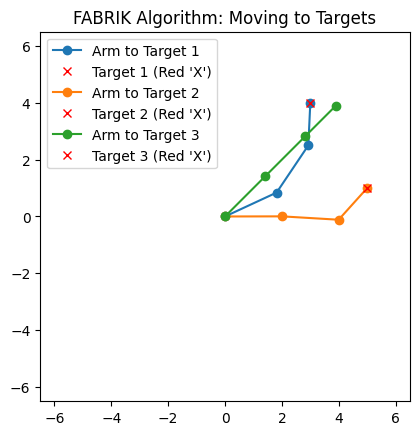

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the FABRIK algorithm
def fabrik(target, joints, link_lengths, tolerance=1e-3, max_iter=100):
    """
    FABRIK algorithm to compute joint positions for a robotic arm.
    """
    num_joints = len(joints)
    total_length = sum(link_lengths)
    target_distance = np.linalg.norm(np.array(target) - np.array(joints[0]))

    if target_distance > total_length:
        # If the target is out of reach, align joints in the direction of the target.
        direction = (np.array(target) - np.array(joints[0])) / target_distance
        for i in range(1, num_joints):
            joints[i] = joints[i - 1] + link_lengths[i - 1] * direction
        return joints

    for _ in range(max_iter):
        # Save the root position for reattachment later
        root = joints[0].copy()

        # Backward Reaching
        joints[-1] = np.array(target)
        for i in range(num_joints - 2, -1, -1):
            r = np.linalg.norm(joints[i + 1] - joints[i])
            joints[i] = joints[i + 1] + (joints[i] - joints[i + 1]) * link_lengths[i] / r

        # Forward Reaching
        joints[0] = root
        for i in range(num_joints - 1):
            r = np.linalg.norm(joints[i + 1] - joints[i])
            joints[i + 1] = joints[i] + (joints[i + 1] - joints[i]) * link_lengths[i] / r

        # Check if the end effector is within tolerance of the target
        if np.linalg.norm(joints[-1] - target) <= tolerance:
            break

    return joints

# Calculate joint angles (in radians)
def calculate_joint_angles(joints, link_lengths):
    """
    Calculate the angles of each joint with respect to the world frame.

    """
    angles = []
    for i in range(1, len(joints)):
        # Calculate the angle
        delta_y = joints[i][1] - joints[i - 1][1]
        delta_x = joints[i][0] - joints[i - 1][0]
        angle = np.arctan2(delta_y, delta_x)
        angles.append(angle)

    # Convert the angles to degrees
    angles_degrees = np.degrees(angles)  # Convert radians to degrees
    return angles_degrees

# Simulate the robot arm
def simulate_robot_arm(joints, link_lengths, targets):
    """
    Simulates and visualizes the robot arm using the FABRIK algorithm.
    """
    fig, ax = plt.subplots()

    # Loop over each target and update the joint positions
    for idx, target in enumerate(targets):
        updated_joints = fabrik(target, joints.copy(), link_lengths)

        # Calculate joint angles in degrees
        joint_angles = calculate_joint_angles(updated_joints, link_lengths)
        print(f"Target {idx+1}: {target}, Joint Angles: {joint_angles}°")  # Print angles in degrees

        # Print the joint positions (after angles)
        joint_positions = [f"({joint[0]:.2f}, {joint[1]:.2f})" for joint in updated_joints]
        print(f"Joint Positions: {joint_positions}\n")  # Print joint positions

        # Plot the arm path (show the target and arm movement)
        ax.plot([p[0] for p in updated_joints], [p[1] for p in updated_joints], '-o', label=f"Arm to Target {idx+1}")

        # Mark the target with a red 'x' and add a label
        ax.plot(target[0], target[1], 'rx', label=f"Target {idx+1} (Red 'X')")

    ax.set_xlim(-sum(link_lengths), sum(link_lengths))
    ax.set_ylim(-sum(link_lengths), sum(link_lengths))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"FABRIK Algorithm: Moving to Targets")

    # Adding legend to indicate what is what
    ax.legend()  # Show the legend with target labels
    plt.show()


# Define robot arm parameters
num_joints = 4
link_lengths = [2, 2, 1.5, 1]  # Length of each link
initial_joints = [np.array([0, 0])]
for i in range(num_joints - 1):
    initial_joints.append(initial_joints[-1] + np.array([link_lengths[i], 0]))

# Define target points
target_points = [
    np.array([3, 4]),   # Reachable target 1
    np.array([5, 1]),   # Reachable target 2
    np.array([10, 10])  # Unreachable target
]

# Run the simulation
simulate_robot_arm(initial_joints, link_lengths, target_points)
